# COMP41680 Assignment 1 - Task 2
- Name: Shuhao Guan
- StudentID: 20211120

In this assignment we will collect detailed health data from the WHO Global Health Observatory open web API for four different indicators.  
This notebook covers **Task 2 - Data Preparation and Analysis**. We will use all of the JSON data collected during Task 1 to perform the analysis process.

WHOSIS_000001 Life expectancy at birth (years)  
WHOSIS_000002 Healthy life expectancy (HALE) at birth (years)  
WHOSIS_000003 Neonatal mortality rate (per 1000 live births)  
WHOSIS_000004 Adult mortality rate (probability of dying between 15 and 60 years per 1000 population)

In [1]:
import json 
from pandas import json_normalize
import urllib.request
import pandas as pd
from datetime import datetime
from pathlib import Path
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.cluster import silhouette_score,rand_score
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pandas.plotting import scatter_matrix
import seaborn as sns
%matplotlib inline
import json, requests, urllib
from pathlib import Path
from datetime import datetime
import warnings

In [2]:
warnings.filterwarnings('ignore')

## Data Preprocessing
Before we can analyse the data, we need to transform it into a usable format.  

Load the data

In [3]:
l=['WHOSIS_000001','WHOSIS_000002','WHOSIS_000003','WHOSIS_000004']
df={}
for i in l:
    df[i]=pd.read_json("raw/"+i+".json")

The format of the dataset for this api is relatively standard, and there are many useless columns in the dataframe for the sake of uniformity of data format. We can delete these columns directly by using the **dropna** function.

In [4]:
for i in df:
    df[i].dropna(axis=1,inplace=True)

Then we need to process the date in the dataframe, cause they are all in the **str** format.

In [5]:
for i in l:
    df[i]['Date']=pd.to_datetime(df[i]['Date'])
    df[i]['TimeDimensionBegin']=pd.to_datetime(df[i]['TimeDimensionBegin'])
    df[i]['TimeDimensionEnd']=pd.to_datetime(df[i]['TimeDimensionEnd'])

## Data Verification

In [6]:
df['WHOSIS_000001'].head(5)

,IndicatorCode,SpatialDimType,SpatialDim,TimeDimType,TimeDim,Dim1Type,Dim1,Value,NumericValue,Date,TimeDimensionValue,TimeDimensionBegin,TimeDimensionEnd
22847621,WHOSIS_000001,COUNTRY,CAN,YEAR,1920,SEX,BTSX,82.8,82.80972,2020-06-04 11:21:09.770000+02:00,1920,1920-01-01 00:00:00+01:00,1920-12-31 00:00:00+01:00
24614321,WHOSIS_000001,COUNTRY,AFG,YEAR,2015,SEX,MLE,61.0,61.03658,2020-12-04 16:59:43.423000+01:00,2015,2015-01-01 00:00:00+01:00,2015-12-31 00:00:00+01:00
24614325,WHOSIS_000001,COUNTRY,AFG,YEAR,2019,SEX,MLE,63.3,63.28709,2020-12-04 16:59:43.533000+01:00,2019,2019-01-01 00:00:00+01:00,2019-12-31 00:00:00+01:00
24614313,WHOSIS_000001,COUNTRY,AFG,YEAR,2000,SEX,MLE,54.6,54.57449,2020-12-04 16:59:42.513000+01:00,2000,2000-01-01 00:00:00+01:00,2000-12-31 00:00:00+01:00
24614317,WHOSIS_000001,COUNTRY,AFG,YEAR,2010,SEX,MLE,59.6,59.60036,2020-12-04 16:59:43.013000+01:00,2010,2010-01-01 00:00:00+01:00,2010-12-31 00:00:00+01:00


In [7]:
df['WHOSIS_000002'].head(5)

,IndicatorCode,SpatialDimType,SpatialDim,TimeDimType,TimeDim,Dim1Type,Dim1,Value,NumericValue,Date,TimeDimensionValue,TimeDimensionBegin,TimeDimensionEnd
24614322,WHOSIS_000002,COUNTRY,AFG,YEAR,2015,SEX,MLE,52.8,52.78430,2020-12-04 16:59:43.457000+01:00,2015,2015-01-01 00:00:00+01:00,2015-12-31 00:00:00+01:00
24614314,WHOSIS_000002,COUNTRY,AFG,YEAR,2000,SEX,MLE,46.9,46.93113,2020-12-04 16:59:42.607000+01:00,2000,2000-01-01 00:00:00+01:00,2000-12-31 00:00:00+01:00
24614318,WHOSIS_000002,COUNTRY,AFG,YEAR,2010,SEX,MLE,51.5,51.50902,2020-12-04 16:59:43.060000+01:00,2010,2010-01-01 00:00:00+01:00,2010-12-31 00:00:00+01:00
24614326,WHOSIS_000002,COUNTRY,AFG,YEAR,2019,SEX,MLE,54.7,54.73407,2020-12-04 16:59:43.563000+01:00,2019,2019-01-01 00:00:00+01:00,2019-12-31 00:00:00+01:00
24614330,WHOSIS_000002,COUNTRY,AFG,YEAR,2000,SEX,FMLE,46.6,46.58344,2020-12-04 16:59:43.643000+01:00,2000,2000-01-01 00:00:00+01:00,2000-12-31 00:00:00+01:00


In [8]:
df['WHOSIS_000003'].head(5)

,IndicatorCode,SpatialDimType,SpatialDim,TimeDimType,TimeDim,Dim1Type,Dim1,Value,NumericValue,Low,High,Date,TimeDimensionValue,TimeDimensionBegin,TimeDimensionEnd
27817348,WHOSIS_000003,REGION,AFR,YEAR,1990,SEX,BTSX,44.8 [43.07-46.77],44.80407,43.06929,46.77133,2022-01-18 13:12:58.117000+01:00,1990,1990-01-01 00:00:00+01:00,1990-12-31 00:00:00+01:00
27817349,WHOSIS_000003,REGION,AFR,YEAR,1991,SEX,BTSX,44.44 [42.76-46.35],44.44097,42.75950,46.34583,2022-01-18 13:12:58.130000+01:00,1991,1991-01-01 00:00:00+01:00,1991-12-31 00:00:00+01:00
27817350,WHOSIS_000003,REGION,AFR,YEAR,1992,SEX,BTSX,44.11 [42.47-46.0],44.11491,42.47348,45.99894,2022-01-18 13:12:58.147000+01:00,1992,1992-01-01 00:00:00+01:00,1992-12-31 00:00:00+01:00
27817351,WHOSIS_000003,REGION,AFR,YEAR,1993,SEX,BTSX,43.81 [42.16-45.68],43.81203,42.15783,45.67856,2022-01-18 13:12:58.147000+01:00,1993,1993-01-01 00:00:00+01:00,1993-12-31 00:00:00+01:00
27817352,WHOSIS_000003,REGION,AFR,YEAR,1994,SEX,BTSX,43.5 [41.88-45.35],43.49713,41.87695,45.34716,2022-01-18 13:12:58.180000+01:00,1994,1994-01-01 00:00:00+01:00,1994-12-31 00:00:00+01:00


In [9]:
df['WHOSIS_000004'].head(5)

,IndicatorCode,SpatialDimType,SpatialDim,TimeDimType,TimeDim,Dim1Type,Dim1,Value,NumericValue,Date,TimeDimensionValue,TimeDimensionBegin,TimeDimensionEnd
19133175,WHOSIS_000004,REGION,AFR,YEAR,2000,SEX,MLE,424,423.8763,2018-05-07 09:06:17.653000+02:00,2000,2000-01-01 00:00:00+01:00,2000-12-31 00:00:00+01:00
19133176,WHOSIS_000004,REGION,AFR,YEAR,2000,SEX,FMLE,371,371.4236,2018-05-07 09:06:17.677000+02:00,2000,2000-01-01 00:00:00+01:00,2000-12-31 00:00:00+01:00
19133177,WHOSIS_000004,REGION,AFR,YEAR,2000,SEX,BTSX,397,397.3357,2018-05-07 09:06:17.700000+02:00,2000,2000-01-01 00:00:00+01:00,2000-12-31 00:00:00+01:00
19133178,WHOSIS_000004,REGION,AFR,YEAR,2001,SEX,MLE,422,421.5305,2018-05-07 09:06:17.723000+02:00,2001,2001-01-01 00:00:00+01:00,2001-12-31 00:00:00+01:00
19133179,WHOSIS_000004,REGION,AFR,YEAR,2001,SEX,FMLE,374,374.2697,2018-05-07 09:06:17.743000+02:00,2001,2001-01-01 00:00:00+01:00,2001-12-31 00:00:00+01:00


We check to see if we have any **missing value** in any of our DataFrames:

In [10]:
for i in l:
    print(i)
    missing = df[i].isnull().sum()
    missing = missing[missing>0]
    if len(missing) == 0:
        print("No Missing value.")
    else:
        print(missing+"missing values")

WHOSIS_000001
No Missing value.
WHOSIS_000002
No Missing value.
WHOSIS_000003
No Missing value.
WHOSIS_000004
No Missing value.


### Data Saving

Now write out all of the DataFrames in JSON format, one file per indicators. These will represent the 'clean' data that we will use next for our actual data analysis:

In [11]:
dir_data = Path("data")
dir_data.mkdir(parents=True, exist_ok=True)

In [12]:
for i in l:
    fname = "%s.json" % i
    out_path = dir_data / fname
    df[i].to_json(out_path)

## Data Analysis

##### 1. WHOSIS_000001 Life expectancy at birth (years)

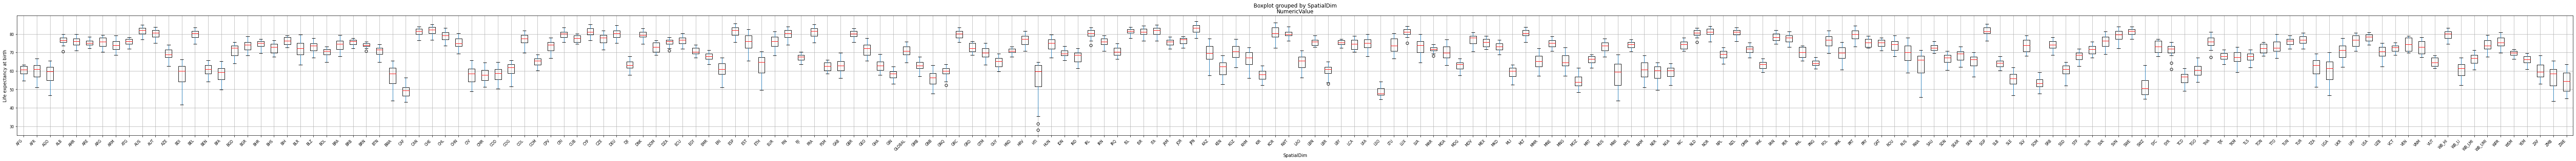

In [13]:
ax = df['WHOSIS_000001'].boxplot(figsize=(100,5), 
                                 fontsize=8,
                                 column='NumericValue',
                                 by='SpatialDim',
                                 medianprops={'color':'red'},
                                 boxprops=dict(color="black"))
ax.set_ylabel("Life expectancy at birth", fontsize=10)
plt.xticks(rotation=45, ha='right');

Because there are too many countries, the **boxplot** is really small, So I've taken a selection to show below. Each box represents a country's Life expectancy at birth indicator.

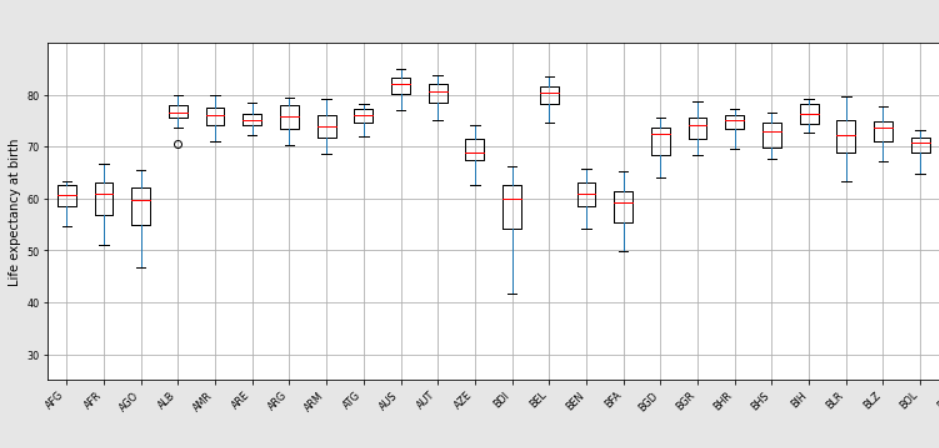

We can use the **groupby** function to find the mean life expectancy at birth for every countries.

In [14]:
df['WHOSIS_000001'].groupby(['SpatialDim']).describe()

TimeDim                                                            \
             count    mean       std     min     25%     50%     75%     max   
SpatialDim                                                                     
AFG           12.0  2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0   
AFR           12.0  2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0   
AGO           12.0  2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0   
ALB           12.0  2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0   
AMR           12.0  2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0   
...            ...     ...       ...     ...     ...     ...     ...     ...   
WSM           12.0  2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0   
YEM           12.0  2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0   
ZAF           12.0  2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0   
ZMB           12.0  2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0   
ZWE           12.0  2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0   

           Value             ... NumericValue           TimeDimensionValue  \
           count       mean  ...          75%       max              count   
SpatialDim                   ...                                             
AFG         12.0  59.958333  ...    62.548258  63.28709               12.0   
AFR         12.0  59.825000  ...    63.043523  66.64575               12.0   
AGO         12.0  58.100000  ...    62.054412  65.51968               12.0   
ALB         12.0  76.466667  ...    78.077900  79.90692               12.0   
AMR         12.0  75.875000  ...    77.457770  79.83914               12.0   
...          ...        ...  ...          ...       ...                ...   
WSM         12.0  69.700000  ...    70.876932  71.84750               12.0   
YEM         12.0  66.158333  ...    68.005632  69.57951               12.0   
ZAF         12.0  60.191667  ...    63.244530  68.28989               12.0   
ZMB         12.0  56.025000  ...    60.985713  65.36993               12.0   
ZWE         12.0  54.258333  ...    59.027653  63.60674               12.0   

                                                                      
              mean       std     min     25%     50%     75%     max  
SpatialDim                                                            
AFG         2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0  
AFR         2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0  
AGO         2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0  
ALB         2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0  
AMR         2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0  
...            ...       ...     ...     ...     ...     ...     ...  
WSM         2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0  
YEM         2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0  
ZAF         2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0  
ZMB         2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0  
ZWE         2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0  

[194 rows x 32 columns]

In [15]:
df['WHOSIS_000001'].groupby(['SpatialDim']).mean().sort_values(by='Value',ascending=False)[['NumericValue']]

,NumericValue
SpatialDim,
JPN,82.875623
CHE,81.949261
AUS,81.731050
ESP,81.567338
ITA,81.554914
...,...
HTI,53.815551
SOM,53.347615
SWZ,51.801628


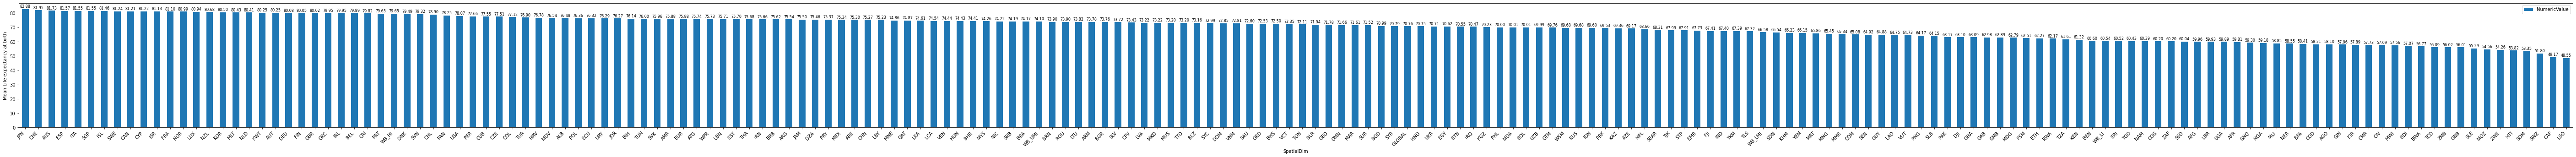

In [16]:
ax = df['WHOSIS_000001'].groupby(['SpatialDim']).mean().sort_values(by='Value',ascending=False)[['NumericValue']].plot.bar(figsize=(100,5), fontsize=10)
ax.set_ylabel("Mean Life expectancy at birth", fontsize=10)
plt.xticks(rotation=45, ha='right')
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + -0.4, b.y1 + 1.0), fontsize=8)

Because there are too many countries, the barplot is really small, So I've taken a selection to show below.  

We can see from the barplot that the **Japanese** people have the longest life expectancy at birth which is **82.88**.   

And the Kingdom of **Lesotho** people have the shortest life expectancy at birth which is **48.55**.    

And the **global** life expectancy at birth is **70.76**.   

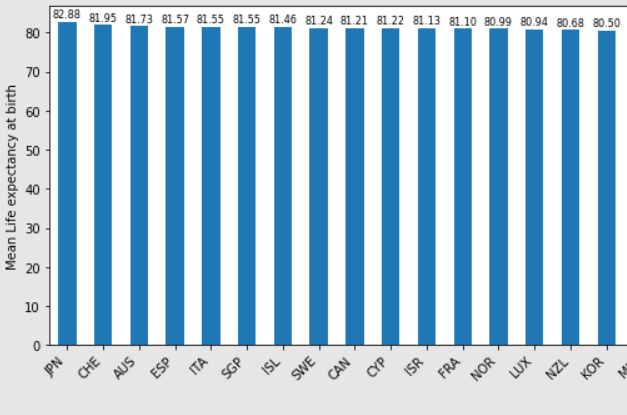

The darker the colour the higher the value of life expectancy at birth, for example Japan and Canada have a very dark blue colour, and the map below is the map I generated by importing the data into tableau.

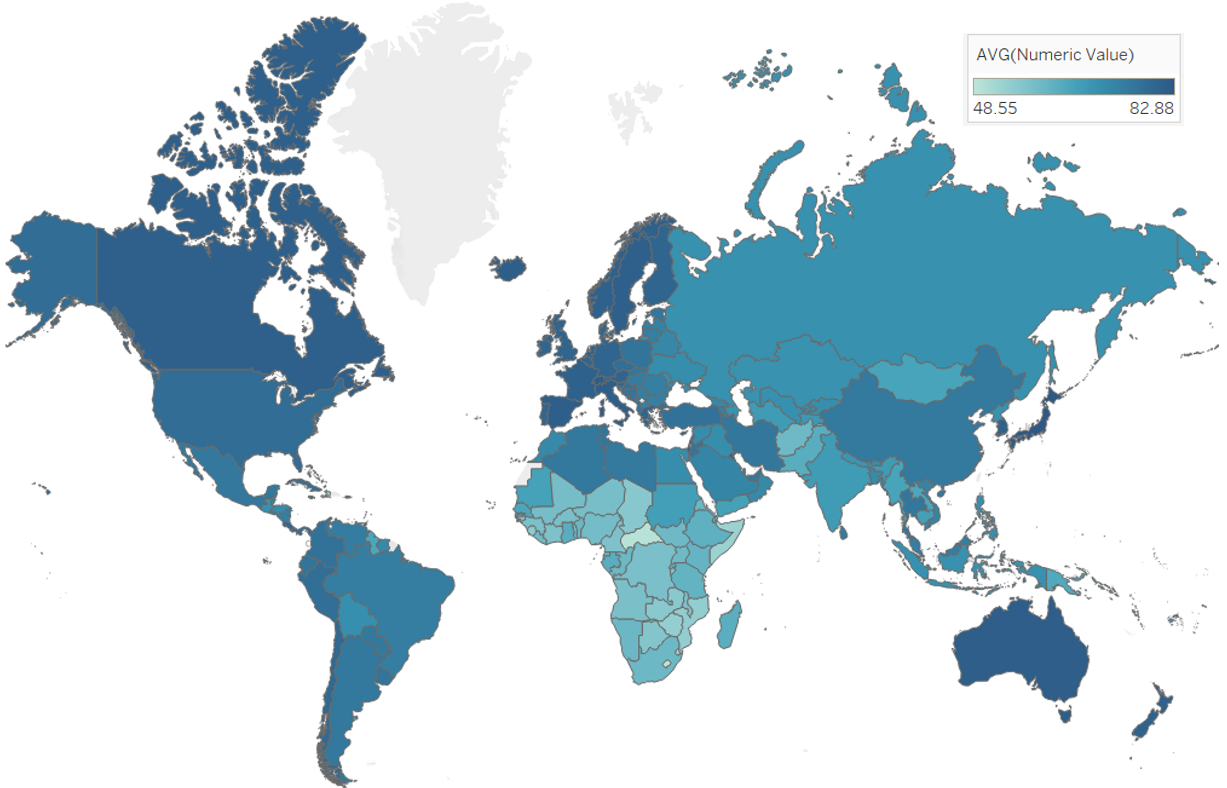

In the **gender** options, we can see that the average life expectancy for women > the average life expectancy for BTSX > the average life expectancy for men.

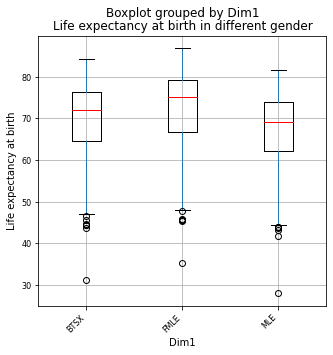

In [17]:
ax = df['WHOSIS_000001'].boxplot(figsize=(5,5), 
                                 fontsize=8,
                                 column='NumericValue',
                                 by='Dim1',
                                 medianprops={'color':'red'},
                                 boxprops=dict(color="black"))
ax.set_ylabel("Life expectancy at birth", fontsize=10)
ax.set_title('Life expectancy at birth in different gender')
plt.xticks(rotation=45, ha='right');

##### 2. WHOSIS_000002 Healthy life expectancy (HALE) at birth (years)

Let's first look at the **distribution** of Healthy life expectancy (HALE) at birth (years) by country region.

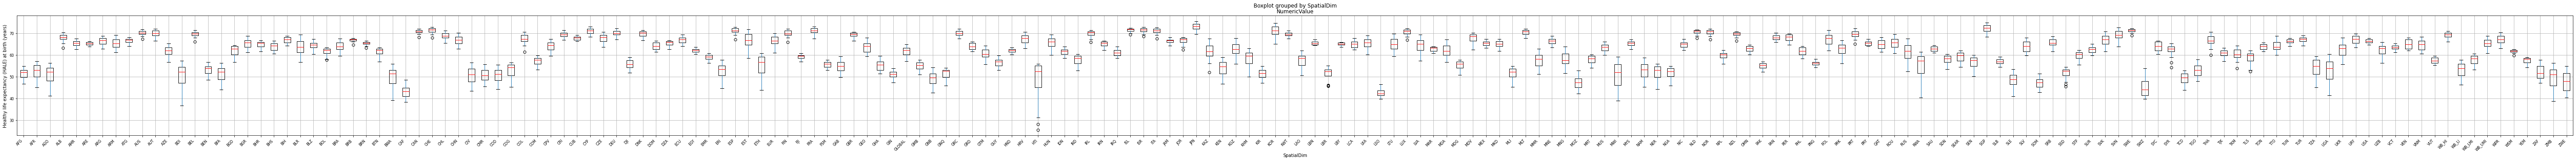

In [18]:
ax = df['WHOSIS_000002'].boxplot(figsize=(100,5), 
                                 fontsize=8,
                                 column='NumericValue',
                                 by='SpatialDim',
                                 medianprops={'color':'red'},
                                 boxprops=dict(color="black"))
ax.set_ylabel("Healthy life expectancy (HALE) at birth (years)", fontsize=10)
plt.xticks(rotation=45, ha='right');

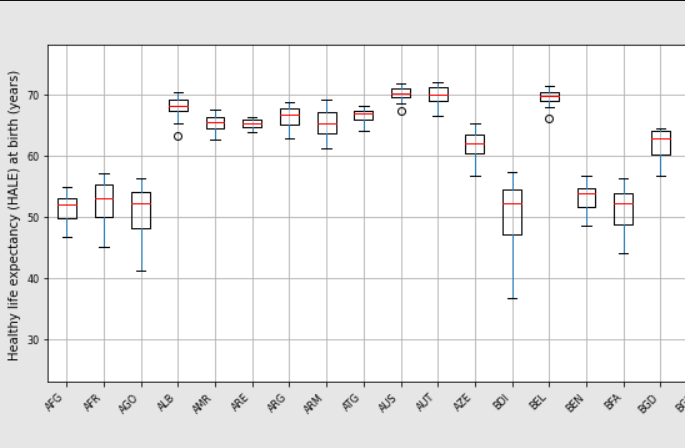

In [19]:
df['WHOSIS_000002'].groupby(['SpatialDim']).describe()

TimeDim                                                            \
             count    mean       std     min     25%     50%     75%     max   
SpatialDim                                                                     
AFG           12.0  2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0   
AFR           12.0  2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0   
AGO           12.0  2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0   
ALB           12.0  2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0   
AMR           12.0  2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0   
...            ...     ...       ...     ...     ...     ...     ...     ...   
WSM           12.0  2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0   
YEM           12.0  2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0   
ZAF           12.0  2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0   
ZMB           12.0  2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0   
ZWE           12.0  2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0   

           Value             ... NumericValue           TimeDimensionValue  \
           count       mean  ...          75%       max              count   
SpatialDim                   ...                                             
AFG         12.0  51.100000  ...    52.876488  54.73407               12.0   
AFR         12.0  52.016667  ...    55.118835  57.09127               12.0   
AGO         12.0  50.541667  ...    53.956670  56.20812               12.0   
ALB         12.0  67.775000  ...    69.037905  70.25225               12.0   
AMR         12.0  65.316667  ...    66.265437  67.50684               12.0   
...          ...        ...  ...          ...       ...                ...   
WSM         12.0  61.583333  ...    62.086557  62.51302               12.0   
YEM         12.0  57.258333  ...    58.465380  58.87235               12.0   
ZAF         12.0  52.100000  ...    54.815062  57.69447               12.0   
ZMB         12.0  48.875000  ...    53.110712  56.31194               12.0   
ZWE         12.0  47.600000  ...    51.552095  54.80482               12.0   

                                                                      
              mean       std     min     25%     50%     75%     max  
SpatialDim                                                            
AFG         2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0  
AFR         2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0  
AGO         2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0  
ALB         2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0  
AMR         2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0  
...            ...       ...     ...     ...     ...     ...     ...  
WSM         2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0  
YEM         2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0  
ZAF         2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0  
ZMB         2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0  
ZWE         2011.0  7.422325  2000.0  2007.5  2012.5  2016.0  2019.0  

[194 rows x 32 columns]

In [20]:
df['WHOSIS_000002'].groupby(['SpatialDim']).mean().sort_values(by='Value',ascending=False)[['NumericValue']]

,NumericValue
SpatialDim,
JPN,73.031365
SGP,72.138597
ISL,71.277738
CHE,71.204969
ISR,71.192851
...,...
HTI,47.152272
SOM,47.013193
SWZ,45.097612


By importing the data into tableau, the following maps can be generated through a series of operations. The darker the colour the longer the healthy life expectancy.

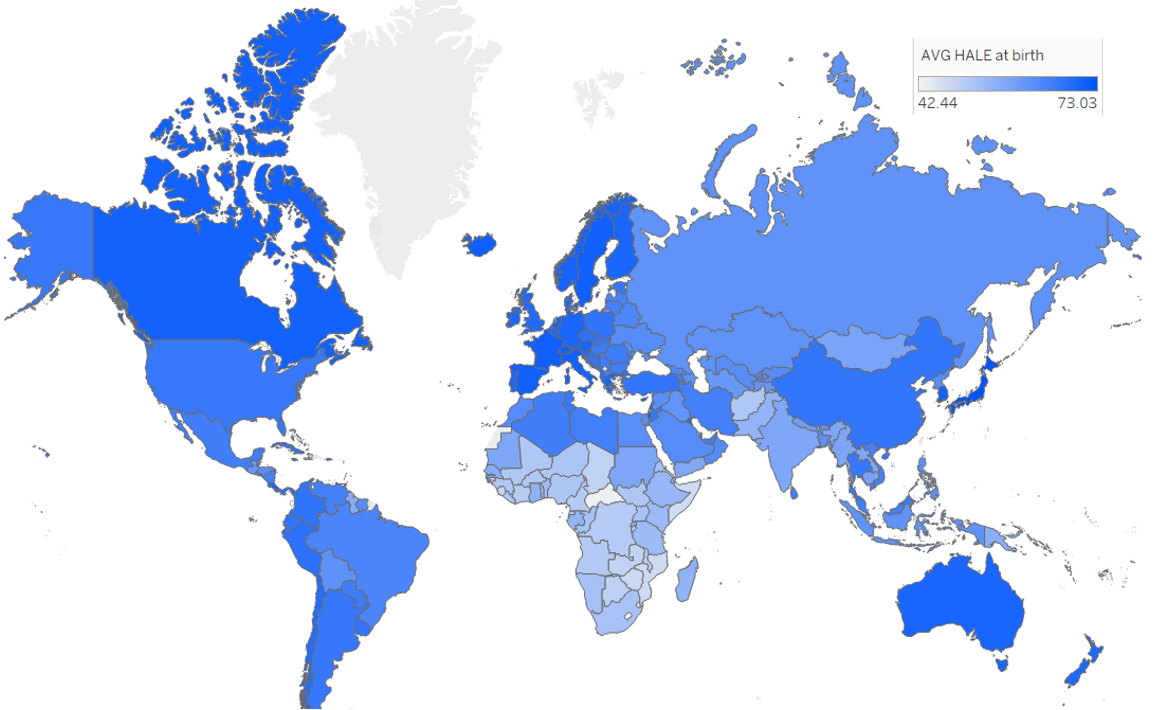

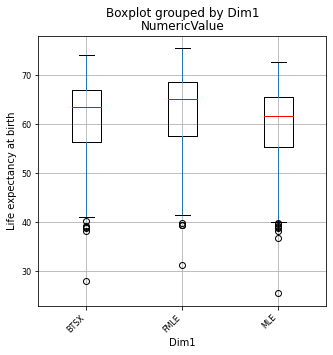

In [21]:
ax = df['WHOSIS_000002'].boxplot(figsize=(5,5), 
                                 fontsize=8,
                                 column='NumericValue',
                                 by='Dim1',
                                 medianprops={'color':'red'},
                                 boxprops=dict(color="black"))
ax.set_ylabel("Life expectancy at birth", fontsize=10)
plt.xticks(rotation=45, ha='right');

In the box plot it can be seen that women have a longer health expectancy compared to men.

##### 3. WHOSIS_000003 Neonatal mortality rate (per 1000 live births)

This dataframe contains data from 1950 to 2020, and I have drawn a **line graph** to show the trend in neonatal mortality.

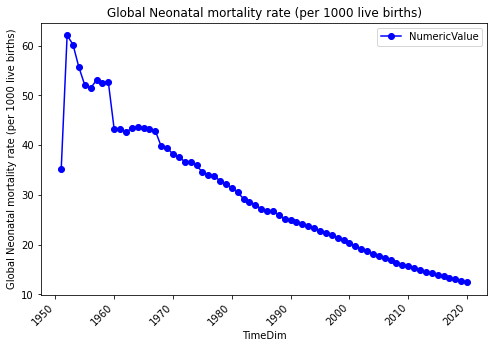

In [22]:
ax = df['WHOSIS_000003'].groupby(['TimeDim']).mean().sort_values(by='TimeDim',ascending=True)[['NumericValue']].plot(figsize=(8,5), fontsize=10,marker='o',color='b',label='Neonatal mortality rate')
ax.set_ylabel("Global Neonatal mortality rate (per 1000 live births)", fontsize=10)
ax.set_title('Global Neonatal mortality rate (per 1000 live births)')
# adjust the x-axis label rotation
plt.xticks(rotation=45, ha='right')
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + -0.4, b.y1 + 1.0), fontsize=8)

It is evident that the global neonatal mortality rate is **decreasing** over time.

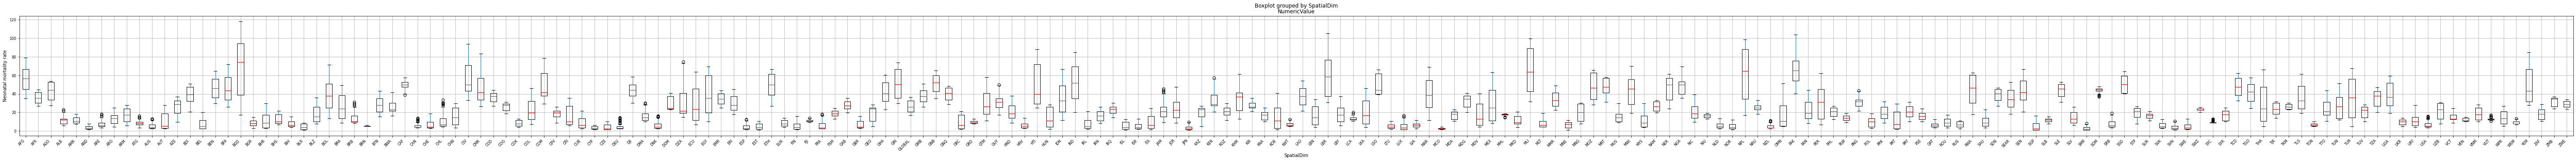

In [23]:
ax = df['WHOSIS_000003'].boxplot(figsize=(100,5), 
                                 fontsize=8,
                                 column='NumericValue',
                                 by='SpatialDim',
                                 medianprops={'color':'red'},
                                 boxprops=dict(color="black"))
ax.set_ylabel("Neonatal mortality rate", fontsize=10)
plt.xticks(rotation=45, ha='right');

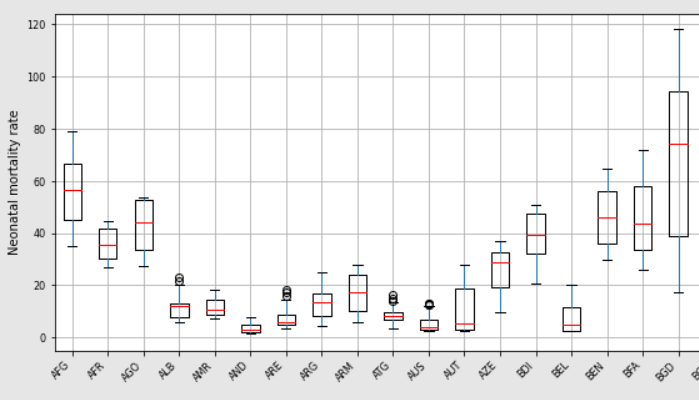

In [24]:
df['WHOSIS_000003'].groupby(['SpatialDim']).describe()

TimeDim                                                       \
             count    mean        std     min      25%     50%      75%   
SpatialDim                                                                
AFG           34.0  2003.5   9.958246  1987.0  1995.25  2003.5  2011.75   
AFR           31.0  2005.0   9.092121  1990.0  1997.50  2005.0  2012.50   
AGO           32.0  2004.5   9.380832  1989.0  1996.75  2004.5  2012.25   
ALB           42.0  1999.5  12.267844  1979.0  1989.25  1999.5  2009.75   
AMR           31.0  2005.0   9.092121  1990.0  1997.50  2005.0  2012.50   
...            ...     ...        ...     ...      ...     ...      ...   
WSM           32.0  2004.5   9.380832  1989.0  1996.75  2004.5  2012.25   
YEM           60.0  1990.5  17.464249  1961.0  1975.75  1990.5  2005.25   
ZAF           46.0  1997.5  13.422618  1975.0  1986.25  1997.5  2008.75   
ZMB           52.0  1994.5  15.154757  1969.0  1981.75  1994.5  2007.25   
ZWE           56.0  1992.5  16.309506  1965.0  1978.75  1992.5  2006.25   

                   NumericValue             ...       High             \
               max        count       mean  ...        75%        max   
SpatialDim                                  ...                         
AFG         2020.0         34.0  56.222171  ...  73.488732   89.48204   
AFR         2020.0         31.0  35.837682  ...  43.549140   46.77133   
AGO         2020.0         32.0  42.763393  ...  63.196525   67.89633   
ALB         2020.0         42.0  11.583708  ...  16.242123   39.17311   
AMR         2020.0         31.0  11.546094  ...  15.013200   18.98227   
...            ...          ...        ...  ...        ...        ...   
WSM         2020.0         32.0   8.859665  ...  12.012892   18.07275   
YEM         2020.0         60.0  49.548820  ...  73.980005  102.32519   
ZAF         2020.0         46.0  18.377952  ...  27.252415   36.43095   
ZMB         2020.0         52.0  32.001602  ...  39.461813   42.44255   
ZWE         2020.0         56.0  28.818093  ...  37.530228   40.64337   

           TimeDimensionValue                                              \
                        count    mean        std     min      25%     50%   
SpatialDim                                                                  
AFG                      34.0  2003.5   9.958246  1987.0  1995.25  2003.5   
AFR                      31.0  2005.0   9.092121  1990.0  1997.50  2005.0   
AGO                      32.0  2004.5   9.380832  1989.0  1996.75  2004.5   
ALB                      42.0  1999.5  12.267844  1979.0  1989.25  1999.5   
AMR                      31.0  2005.0   9.092121  1990.0  1997.50  2005.0   
...                       ...     ...        ...     ...      ...     ...   
WSM                      32.0  2004.5   9.380832  1989.0  1996.75  2004.5   
YEM                      60.0  1990.5  17.464249  1961.0  1975.75  1990.5   
ZAF                      46.0  1997.5  13.422618  1975.0  1986.25  1997.5   
ZMB                      52.0  1994.5  15.154757  1969.0  1981.75  1994.5   
ZWE                      56.0  1992.5  16.309506  1965.0  1978.75  1992.5   

                             
                75%     max  
SpatialDim                   
AFG         2011.75  2020.0  
AFR         2012.50  2020.0  
AGO         2012.25  2020.0  
ALB         2009.75  2020.0  
AMR         2012.50  2020.0  
...             ...     ...  
WSM         2012.25  2020.0  
YEM         2005.25  2020.0  
ZAF         2008.75  2020.0  
ZMB         2007.25  2020.0  
ZWE         2006.25  2020.0  

[202 rows x 40 columns]

In [25]:
df['WHOSIS_000003'].groupby(['SpatialDim']).mean().sort_values(by='NumericValue',ascending=False)[['NumericValue']]

,NumericValue
SpatialDim,
BGD,69.012837
PAK,66.967284
MLI,64.933472
NPL,61.595161
LBR,59.984016
...,...
AND,3.512023
CYP,3.303390
JPN,3.233978


The country with the highest neonatal mortality rate is **BGD**, with 69 deaths per 1,000 births. The country with the lowest neonatal mortality rate is **MCO**, with only 2 deaths per 1,000 births.

##### 4. WHOSIS_000004 Adult mortality rate (probability of dying between 15 and 60 years per 1000 population)

In [26]:
df['WHOSIS_000004'].groupby(['SpatialDim']).describe()

TimeDim                                                            \
             count    mean       std     min     25%     50%     75%     max   
SpatialDim                                                                     
AFG           51.0  2008.0  4.947727  2000.0  2004.0  2008.0  2012.0  2016.0   
AFR           51.0  2008.0  4.947727  2000.0  2004.0  2008.0  2012.0  2016.0   
AGO           51.0  2008.0  4.947727  2000.0  2004.0  2008.0  2012.0  2016.0   
ALB           51.0  2008.0  4.947727  2000.0  2004.0  2008.0  2012.0  2016.0   
AMR           51.0  2008.0  4.947727  2000.0  2004.0  2008.0  2012.0  2016.0   
...            ...     ...       ...     ...     ...     ...     ...     ...   
WSM           51.0  2008.0  4.947727  2000.0  2004.0  2008.0  2012.0  2016.0   
YEM           51.0  2008.0  4.947727  2000.0  2004.0  2008.0  2012.0  2016.0   
ZAF           51.0  2008.0  4.947727  2000.0  2004.0  2008.0  2012.0  2016.0   
ZMB           51.0  2008.0  4.947727  2000.0  2004.0  2008.0  2012.0  2016.0   
ZWE           51.0  2008.0  4.947727  2000.0  2004.0  2008.0  2012.0  2016.0   

           Value              ... NumericValue           TimeDimensionValue  \
           count        mean  ...          75%       max              count   
SpatialDim                    ...                                             
AFG         51.0  265.843137  ...    286.04700  340.3936               51.0   
AFR         51.0  346.745098  ...    384.83995  423.8763               51.0   
AGO         51.0  297.666667  ...    336.80505  423.0116               51.0   
ALB         51.0  101.176471  ...    125.08760  133.6237               51.0   
AMR         51.0  132.392157  ...    162.91570  184.7016               51.0   
...          ...         ...  ...          ...       ...                ...   
WSM         51.0  143.137255  ...    170.77340  222.2624               51.0   
YEM         51.0  239.294118  ...    256.26255  273.1234               51.0   
ZAF         51.0  401.372549  ...    457.86365  511.8771               51.0   
ZMB         51.0  447.784314  ...    570.70715  625.4789               51.0   
ZWE         51.0  551.450980  ...    673.13080  728.4456               51.0   

                                                                      
              mean       std     min     25%     50%     75%     max  
SpatialDim                                                            
AFG         2008.0  4.947727  2000.0  2004.0  2008.0  2012.0  2016.0  
AFR         2008.0  4.947727  2000.0  2004.0  2008.0  2012.0  2016.0  
AGO         2008.0  4.947727  2000.0  2004.0  2008.0  2012.0  2016.0  
ALB         2008.0  4.947727  2000.0  2004.0  2008.0  2012.0  2016.0  
AMR         2008.0  4.947727  2000.0  2004.0  2008.0  2012.0  2016.0  
...            ...       ...     ...     ...     ...     ...     ...  
WSM         2008.0  4.947727  2000.0  2004.0  2008.0  2012.0  2016.0  
YEM         2008.0  4.947727  2000.0  2004.0  2008.0  2012.0  2016.0  
ZAF         2008.0  4.947727  2000.0  2004.0  2008.0  2012.0  2016.0  
ZMB         2008.0  4.947727  2000.0  2004.0  2008.0  2012.0  2016.0  
ZWE         2008.0  4.947727  2000.0  2004.0  2008.0  2012.0  2016.0  

[190 rows x 32 columns]

In [27]:
df['WHOSIS_000004'].groupby(['SpatialDim']).mean().sort_values(by='NumericValue',ascending=False)[['NumericValue']]

,NumericValue
SpatialDim,
ZWE,551.465735
LSO,540.021641
SWZ,532.298135
CAF,491.918751
SLE,452.183680
...,...
ITA,62.208925
SWE,62.029060
MLT,61.215640


As the dataframe shows, **ZWE** has the highest adult mortality rate, nearly 55% of adult dead before 60 years old. And the **ISL** has the lowest adult mortality rate, Only 59 out of 1000 people die before the age of 60.

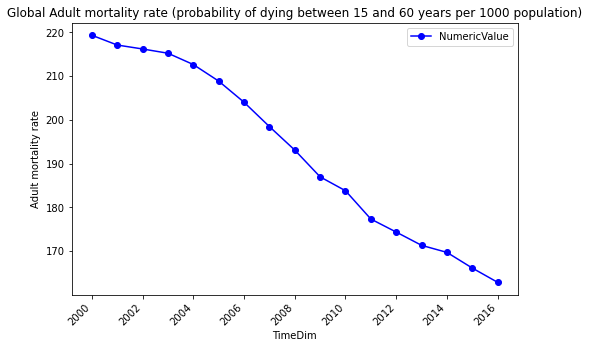

In [28]:
ax = df['WHOSIS_000004'].groupby(['TimeDim']).mean().sort_values(by='TimeDim',ascending=True)[['NumericValue']].plot(figsize=(8,5), fontsize=10,marker='o',color='b',label='Neonatal mortality rate')
ax.set_ylabel("Adult mortality rate", fontsize=10)
ax.set_title('Global Adult mortality rate (probability of dying between 15 and 60 years per 1000 population)')
# adjust the x-axis label rotation
plt.xticks(rotation=45, ha='right')
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + -0.4, b.y1 + 1.0), fontsize=8)

We can see that the adult mortality rate has been **decreasing** over the period 2000-2016.

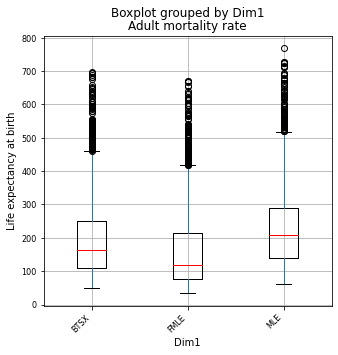

In [29]:
ax = df['WHOSIS_000004'].boxplot(figsize=(5,5), 
                                 fontsize=8,
                                 column='NumericValue',
                                 by='Dim1',
                                 medianprops={'color':'red'},
                                 boxprops=dict(color="black"))
ax.set_ylabel("Life expectancy at birth", fontsize=10)
ax.set_title('Adult mortality rate')
plt.xticks(rotation=45, ha='right');

As I thought, because women have a longer life expectancy, women also have a somewhat lower mortality rate than men.

## Correlations Between Indicators

In [30]:
df1=df['WHOSIS_000001'].groupby(['SpatialDim']).mean().sort_values(by='Value',ascending=False)[['NumericValue']]
df1.columns=['Life expectancy']
df2=df['WHOSIS_000002'].groupby(['SpatialDim']).mean().sort_values(by='Value',ascending=False)[['NumericValue']]
df2.columns=['HALE']
df3=df['WHOSIS_000003'].groupby(['SpatialDim']).mean().sort_values(by='NumericValue',ascending=False)[['NumericValue']]
df3.columns=['Neonatal mortality rate']
df4=df['WHOSIS_000004'].groupby(['SpatialDim']).mean().sort_values(by='NumericValue',ascending=False)[['NumericValue']]
df4.columns=['Adult mortality rate']

**Join** the dataframe.

In [31]:
df_good=pd.concat([df1,df2,df3,df4],axis=1,join='inner')

Text(0.5, 1.0, 'Temperature Correlations')

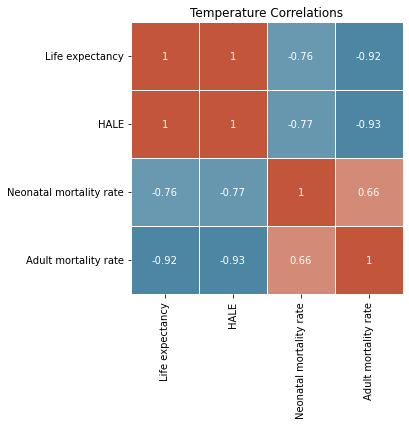

In [32]:
df_corr = df_good.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(df_corr, square=True, cbar=False,
            annot=True, cmap=cmap, linewidths=0.5, vmin=-1)
ax.set_title("Temperature Correlations")

As I expected, life expectancy and HALE are strongly correlated and they are strongly negatively correlated with mortality.

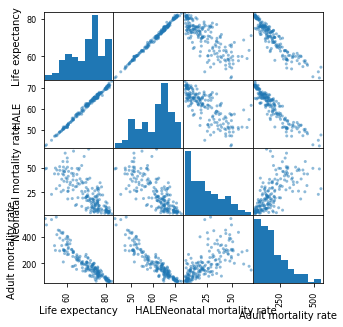

In [33]:
ax = scatter_matrix(df_good, figsize=(5,5), alpha=0.5)

I normalised the data and then ran a series of operations to create a heat map to show the scores of each country on the different indicators.

In [34]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_T_minmax = min_max_scaler.fit_transform(df_good)
df_good2 = (df_good-df_good.min())/(df_good.max()-df_good.min())

In [35]:
df_good2['Neonatal mortality rate']=abs(df_good2['Neonatal mortality rate']-1)
df_good2['Adult mortality rate']=abs(df_good2['Adult mortality rate']-1)
df_good2=df_good2*100

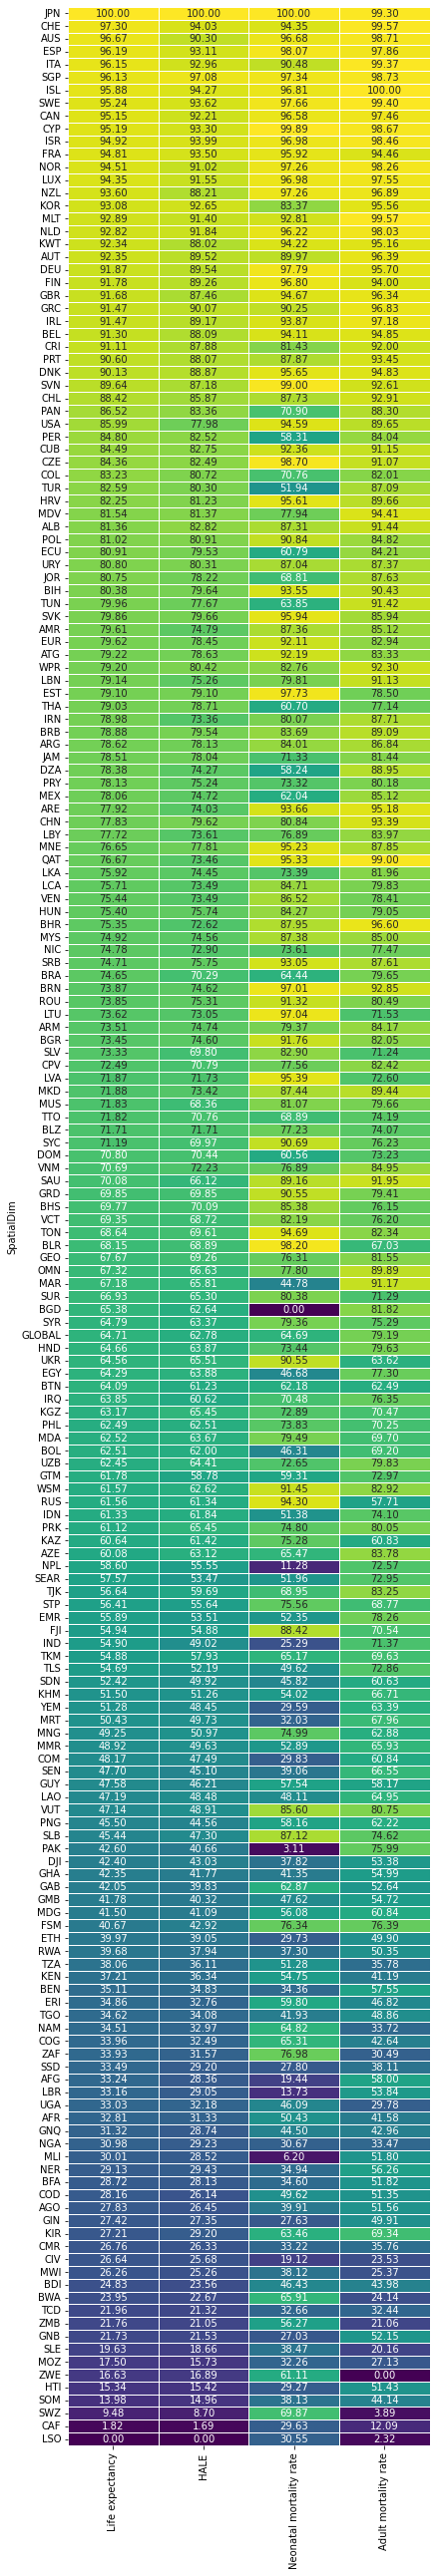

In [36]:
cmap = sns.color_palette("viridis", as_cmap=True)
f, ax = plt.subplots(figsize=(6.5,45))
h = sns.heatmap(df_good2, square=False, cbar=False,
            annot=True, fmt='.2f', cmap=cmap, linewidths=0.5, vmin=0)

This gives a better visualisation of how different countries score on different indicators.

## Data Clustering Analysis

First we need to determine the number of clusters.

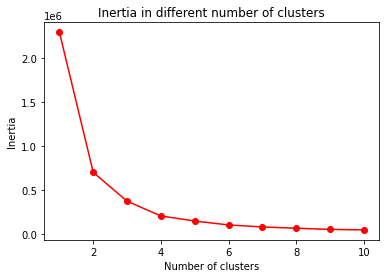

In [37]:
X=df_good.values
from sklearn.cluster import KMeans
l1=[]
l2=[]
for i in range(10):
    clf = KMeans(n_clusters=i+1,random_state=0)
    clf.fit(X)
    l1.append(clf.inertia_)
    l2.append(i+1)
plt.plot(l2,l1,'ro-')
plt.ylabel("Inertia")
plt.xlabel("Number of clusters")
plt.title("Inertia in different number of clusters")
plt.show()

3 is the best number. The inertia values will decrease with the increase of the category, but for the data with a certain degree of discrimination, the inertia values will be greatly decreased when it reaches a certain critical point, and then slowly decreases. This critical point can be considered as the point with better clustering performance.

#### K-means

In [38]:
clf = KMeans(n_clusters=3,n_init=100,max_iter=100,random_state=5)
clf.fit(X)

KMeans(max_iter=100, n_clusters=3, n_init=100, random_state=5)

In [39]:
print('Silhouette Score is',silhouette_score(X, clf.predict(X)))

Silhouette Score is 0.5440961502915984


Silhouette Score is acceptable.

In [40]:
df_good['labels']=clf.labels_
df_good.to_csv('map1.csv')

For a better visualisation of these data, I put them into tableau and generated a map accordingly. I implemented the K-means algorithm on this dataframe, and I put all countries into three clusters, and I highlight the countries  which have high national health quality in blue, the darker the blue, the better the national health quality of the country.

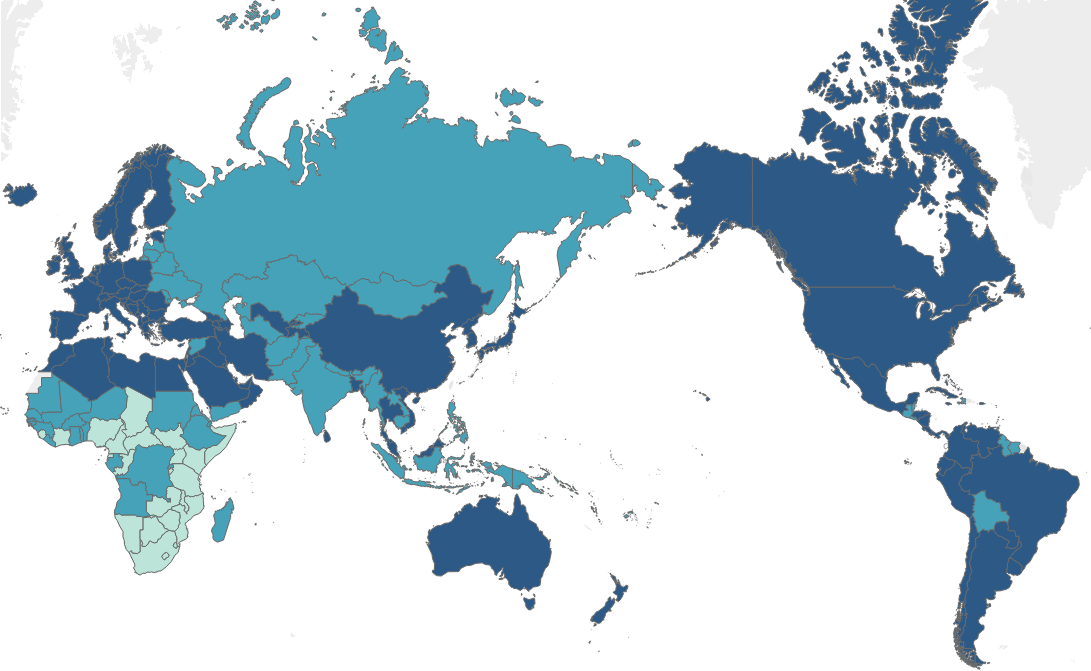

## Conclusions

- In this task, we will collect detailed health data from the WHO Global Health Observatory open web API for four different indicators. They are recorded separately for different countries over different periods for a range of They record a range of national health measures for different countries over time. For the analysis in this paper, we first analyzed each of the four indicators, looking at the distribution and mean of each indicator and ranking each country. In general, the quality of national health is greater in developed countries than in developing countries, women appear to be healthier than men, and the health of the global population is getting better over time.  

  The four indicators were then analyzed for correlation, then scored after normalizing the four indicators, and then a heat map was used to show the scores obtained for each country. The Kmeans algorithm was then used to cluster all the countries, and the map was then colored to indicate the different clusters, and it can be seen that the darker colors are concentrated in developed countries such as Europe and the Americas, as well as a small number of developing countries with good national health levels; Africa has poor national health levels.
  
  WHO has good free api's and we can choose our own suitable indicator api's from hundreds of api's. In my assignment, I only chose four indicators and I can analyse more indicators to further analyse the WHO data, for example, through decision trees or regressions to predict information such as people's life expectancy.